In [48]:
import torch
from mlutil.trainer import Trainer
from mlutil.datasets import FashionMNISTSet

In [49]:
class CustomDropout(torch.nn.Module):
    def __init__(self, p=0.5, training=True):
        super().__init__()
        self.p = p if training else 0.0

    def forward(self, x):
        if self.p == 1:
            return torch.zeros_like(x)
        mask = torch.rand(x.shape) > self.p
        out = x * mask / (1 - self.p)
        return out

In [50]:
class DropoutNet(torch.nn.Module):
    def __init__(self, out_dim, h1_dim, h2_dim, dropout_1, dropout_2, train=True) -> None:
        super().__init__()
        
        self.linear1 = torch.nn.LazyLinear(h1_dim)
        self.linear2 = torch.nn.LazyLinear(h2_dim)
        self.linear_3 = torch.nn.LazyLinear(out_dim)
        
        self.dropout_1 = CustomDropout(dropout_1, train)
        self.dropout_2 = CustomDropout(dropout_2, train)
        
        self.relu = torch.nn.ReLU()
        
    def train_step(self, batch):
        self.opt.zero_grad()
        x, y = batch
        y_hat = self(x)
        loss = torch.nn.functional.cross_entropy(y_hat, y)
        loss.backward()
        self.opt.step()
        return loss.item()

    def val_step(self, batch):
        with torch.no_grad():
            x, y = batch
            y_hat = self(x)
            loss = torch.nn.functional.cross_entropy(y_hat, y)
            return loss.item()
        
    def forward(self, x):
        h1 = self.relu(self.linear1(x.reshape(x.shape[0], -1)))
        h1 = self.dropout_1(h1)
        h2 = self.relu(self.linear2(h1))
        h2 = self.dropout_2(h2)
        return self.linear_3(h2)
        
    def config_optimizer(self, lr):
        self.opt = torch.optim.SGD(self.parameters(), lr=lr)        

In [51]:
hparams = {'out_dim':10, 'h1_dim':256, 'h2_dim':256,
           'dropout_1':0.5, 'dropout_2':0.5}
model = DropoutNet(**hparams)
model.config_optimizer(lr=0.1)

In [52]:
dataset = FashionMNISTSet(batch_size=128)
trainer = Trainer(epochs=10)
trainer.train(model, dataset.create_dataloader(train=True), dataset.create_dataloader(train=False))

Epoch: 0, Train Loss: 0.951, Val Loss: 0.663
Epoch: 1, Train Loss: 0.579, Val Loss: 0.557
Epoch: 2, Train Loss: 0.509, Val Loss: 0.528
Epoch: 3, Train Loss: 0.468, Val Loss: 0.493
Epoch: 4, Train Loss: 0.451, Val Loss: 0.485
Epoch: 5, Train Loss: 0.431, Val Loss: 0.462
Epoch: 6, Train Loss: 0.416, Val Loss: 0.448
Epoch: 7, Train Loss: 0.404, Val Loss: 0.449
Epoch: 8, Train Loss: 0.393, Val Loss: 0.439
Epoch: 9, Train Loss: 0.385, Val Loss: 0.427


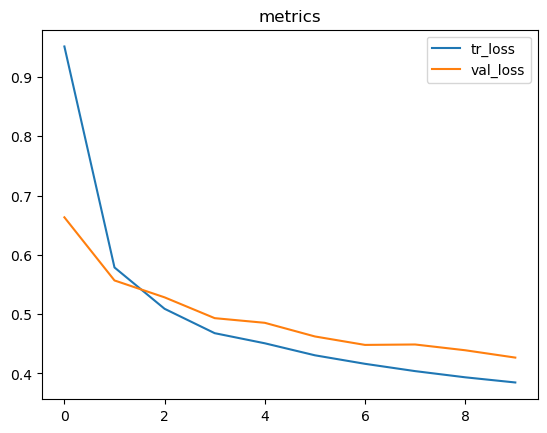

In [53]:
trainer.plot()